In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Introduction
---
In this notebook, we have tested two approaches for multimodal classification of e-commerce products into **prdtypecode** exploiting at the same time both text and images data:
1. Training a Logistic Regression classifier with features extracted from images by means of a pre-trained convolutional neural network (VGG16) joined with text 
2. Building a deep learning model adapted to accept both images and text features by concateneting two different Neural Network architectures (RNN and CNN)


In [2]:
# ---------------------------------------------------------------------------
# Import des librairies
# ---------------------------------------------------------------------------

import numpy as np
import pandas as pd

import sys
import os
import time
import datetime
from timeit import default_timer as timer
from packaging import version
import itertools  #
import glob
import pickle

# Librairies sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report,  accuracy_score, confusion_matrix

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import joblib #

#  tensorflow Libraries
from keras.applications.xception import Xception, preprocess_input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, BatchNormalization,GlobalAveragePooling2D,LSTM,concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, xception
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback, EarlyStopping

#import stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#defining a countvectorizer with english, german and french stopwords
from sklearn.feature_extraction.text import CountVectorizer
stop_words_ge = set(stopwords.words("german"))
stop_words_fr = set(stopwords.words('french'))
stop_words_en = set(stopwords.words('english'))
stop_words = set.union(stop_words_en,stop_words_fr,stop_words_ge)

# Load the TensorBoard notebook extension.
%load_ext tensorboard
import tensorboard

# Google Colab
from google.colab import drive
%tensorflow_version 2.x

print("Modules importation successful")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Modules importation successful


In [3]:
#--------------------------------
#Creating a destination directory and copy paste the unzipped images folders there
#--------------------------------

# Switch to bash (cell-wise)
%%bash

# Images source and destination
SRC1="/content/drive/MyDrive/eBimPy/images/image_train.zip"
SRC2="/content/drive/MyDrive/eBimPy/images/image_test.zip"
DEST="/tmp/eBimPy"
#DEST="/tmp/eBimPy/images/image_test"

#rm -r $DEST
# Check it has not been done
if [ -d "$DEST" ]; then
    echo "Images already unzipped"
else
    # Create directory
    mkdir -p "$DEST"
    # Unzip images
    unzip -q "$SRC1" -d "$DEST"
    unzip -q "$SRC2" -d "$DEST"
    echo "Images unzipped"
fi
#!wget /content/drive/My Drive/eBimPy/images/image_train
#!unzip image_train.zip

#os.chdir('/tmp/eBimPy/images/')
#!ls


Images unzipped


In [4]:
# ---------------------------------------------------------------------------
# Configuration of the main model parameters
# ---------------------------------------------------------------------------

# Path for accessing images and dataset
inRep = r"/content/drive/MyDrive/eBimPy/"
outRep = r"/content/drive/MyDrive/eBimPy/out/"
train_path = "/tmp/eBimPy/image_train/"
test_path = "/content/image_test/image_"
checkpoint_dir = "/tmp/classification/models/"
model_savepath    = r"/content/drive/MyDrive/eBimPy/saved_models/"

# Images size - limited due to RAM
width = 64
height = 64

# General parameters for the model fitting
TEST_SIZE = 0.20
VALIDATION_SPLIT = 0.3
EPOCH      = 2     # number of epochs 
BATCH_SIZE = 32     # size of the batch
CLASS_MODE = "categorical"

#dictionary associating a category name to each prdtypecode defined in the machine learning notebook
dic= {10:"livres scolaires, guides, biographies",2280:"magazines, journaux, presse",50:"accessoires de console de jeux vidéo",1280:"peluche, figurine, jeux d'enfants",2705:"sciences humaines et philosophie",2522:"papeterie",2582:"meubles de jardin",1560:"décoration intérieure",1281:"jeux de société pour enfants",1920:"accessoires de chambre",2403:"séries, bandes dessinées et collections",1140:"articles d'anime et de starwars",2583:"piscine",1180:"fantasy et horror",1300:"drones",2462:"consoles et jeux vidéo",1160:"cartes et figurines",2060:"accessoires et décorations pour la maison",40:"jeux vintage",60:"consoles vintage",1320:"accessoires pour bébés",1302:"jeux et accessoires pour enfants",2220:"accessoires pour animaux",2905:"jeux vidéo sur pc",2585:"outils de jardinage",1940:"snack",1301:"salle de jeux e chaussures enfants"}



In [5]:
#-------------------------------------------------------------------------------
# function for plotting the accuracy and loss curves for both train and test sets
#-------------------------------------------------------------------------------

def plot_graphs(history, string):
  plt.figure(figsize=(8,8))
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [6]:
#----------------------------------------------------------------------------------------------------------------
#Function generating features extracted from images and corresponding layers used in the transfer learning section
#----------------------------------------------------------------------------------------------------------------

def extract_features(df, sample_count,BATCH_SIZE=BATCH_SIZE):
    features = np.zeros(shape=(sample_count, 2, 2, 512 ))
    labels = np.zeros(shape=(sample_count, 27))

# generator used to extract images from the their directories throgh the path column included in the datafram
    generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
        dataframe=df,
        x_col="path",
        y_col="prdtypecode", 
        shuffle=False,         
        color_mode= "rgb",                                                             
        target_size=(width, height),
        batch_size = BATCH_SIZE, 
        class_mode=CLASS_MODE)

    i = 0

    print('Entering for loop...');

# extraction of the features from each batch by means of the pre trained model 
    for inputs_batch, labels_batch in generator:
        features_batch = VGG_model.predict(inputs_batch)
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels, generator.class_indices

In [7]:
#----------------------------------------------------------------------------------------
#function used to generate train and test sets out of images in the hybrid model section
#-----------------------------------------------------------------------------------------

def extract_images(df):
    generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=df,
    x_col="path",
    y_col="prdtypecode", 
    shuffle=False,         
    color_mode= "rgb",
    batch_size=BATCH_SIZE,                                                             
    target_size=(width, height), 
    class_mode=CLASS_MODE)

    X_im = np.zeros(shape=(len(df), width, height, 3))
    y_im = np.zeros(shape=(len(df), 27))
    i=0

    for inputs_batch, labels_batch in generator:
          X_im[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = inputs_batch
          y_im[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
          i += 1
          if i * BATCH_SIZE >= len(df):
              break
    return X_im, y_im, generator.class_indices

In [8]:
#---------------------------------------------
#functions for removing tags and html characters 
#-----------------------------------------------

def remove_tags(string):
  result = re.sub('<.*?>','',string)
  return result
def remove_html_code(string):
  result = re.sub('\w*&#\d+','',string)
  return result

In [9]:
#---------------------------------------------------------------------------------
# Definition of a preprocessing function for the vectorization of the text feature
#---------------------------------------------------------------------------------
def preprocessing(df,tokenizer):

  #splitting of the dataset into train and test sets
  # Split des données : 80% entrainement (train et validation) et 20% test. 
  df_train, df_test = train_test_split(df, test_size=TEST_SIZE, stratify=df["prdtypecode"],random_state=456)
  
  #fitting the tokenizer on the text in order to create a vocabulary of most common words
  tokenizer.fit_on_texts(df_train["text_no_stopwords"])

  #creating useful variables to go from text to index and viceversa
  word2idx = tokenizer.word_index
  idx2word = tokenizer.index_word

  #Vocabolary size
  vocab_size = tokenizer.num_words

  #vectorization of the text into sequences of indexes 
  X_train = tokenizer.texts_to_sequences(df_train["text_no_stopwords"])
  X_test = tokenizer.texts_to_sequences(df_test["text_no_stopwords"])

  #padding of shorter word vectors with zeros in order to keep the same length for each
  X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train)
  X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test)
  
  return tokenizer,word2idx,idx2word,vocab_size,X_train,X_test,df_train,df_test

In [10]:
# defining early stopping callbacks to stop the fitting at the minimum of validation loss accuracy
early_stopping = EarlyStopping(monitor='val_loss',
                        patience=1,
                        mode='min',
                        restore_best_weights=True)

# Preprocessing
---


In [11]:
#loading datasets and labels
df_image = pd.read_csv("/content/drive/MyDrive/X_train_update.csv",index_col = 0)
df_label = pd.read_csv("/content/drive/MyDrive/Y_train_CVw08PX.csv",index_col = 0)

#concatenate features and labels (prdtypecode)
df = pd.concat([df_image,df_label],axis=1)

#joining the variables designation and description into the variable text
df["text"] = df["designation"].fillna("").astype("str") + ". "+ df["description"].fillna("").astype("str")

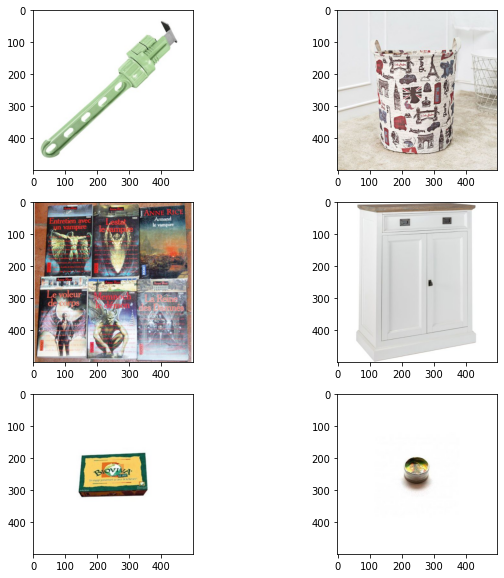

In [12]:
# Visualization of some images to check everything works fine
%matplotlib inline
plt.figure(figsize = (10, 10))

number_of_images = 6 

i = 0
files = glob.glob(train_path + '*.jpg')

for name in files[:number_of_images]:
    #print(name)
    file = mpimg.imread(name)
    plt.subplot(number_of_images//2,2,i+1)
    plt.imshow(file)
    i +=1

    

In [13]:
#-----------------------------------------------------------------------------------------------
# Integration of a new column containing the path towards the image corresponding to each item
#----------------------------------------------------------------------------------------------

# images_path dictionary {(imageid, productid) : image path}
images_path = {}
files = glob.glob(train_path + '/*.jpg')

for f in files:
    try:
        name = os.path.basename(f)
        imageid = int(name.split('_')[1])
        productid = int(name.split('_')[-1].split('.')[0])
        images_path[(imageid,productid)] = f
        
    except :
        print(f)
        
# Application of the dictionary to df
df['path'] = df.set_index(['imageid', 'productid']).index.map(images_path)

#convert to string
df = df.astype('str')

# Affichage du dataframe avec la variable chemins des images
display(df.head())


,designation,description,productid,imageid,prdtypecode,text,path
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,nan,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,/tmp/eBimPy/image_train/image_1263597046_produ...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,nan,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,/tmp/eBimPy/image_train/image_1008141237_produ...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,/tmp/eBimPy/image_train/image_938777978_produc...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,nan,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,/tmp/eBimPy/image_train/image_457047496_produc...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,La Guerre Des Tuques. Luc a des id&eacute;es d...,/tmp/eBimPy/image_train/image_1077757786_produ...


# Transfer Learning 
---
A VGG16 pretrained model has been employed as feature extractor to create new features out of the image dataset.The features extracted from the images have been joined with the count vectorized text feature of the dataframe and used to fit a logistic regression algorithm 

In [14]:
#load a VGG model without classification layers
VGG_model = VGG16(weights='imagenet',include_top=False,input_shape=(width,height,3))
 
#Since we are using the VGG model as feature extractor, make all the loaded layers as non-trainable 
for layer in VGG_model.layers:
    layer.trainable = False
VGG_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [15]:
#split dataframe into a training and test set containing also the target and keeping the target proportions within each split
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, stratify=df['prdtypecode'], random_state=42)

#applying the function to extract the features out of the images 
feature_train, y_train_im, class_indices_train = extract_features(df_train, len(df_train))
feature_test, y_test_im, class_indices_test = extract_features(df_test, len(df_test))





Found 67932 validated image filenames belonging to 27 classes.
Entering for loop...
Found 16984 validated image filenames belonging to 27 classes.
Entering for loop...


In [16]:
# with open(model_savepath+'feature_train_vgg.txt', 'rb') as f:
#     feature_train = pickle.load(f)

- Since the VGG model gives as output a tensor (see model summary) we need to flatten to be able to use it afterwards for the machine learning algorithm

In [17]:
#flattening of the feature_train and feature_test matrices to be fed to a Logistic Regression algorithm
features_train = feature_train.reshape(feature_train.shape[0],feature_train.shape[1]*feature_train.shape[2]*feature_train.shape[3])
features_test = feature_test.reshape(feature_test.shape[0],feature_test.shape[1]*feature_test.shape[2]*feature_test.shape[3])


In [18]:
#definition of a Count Vectorizer which does not consider stopwords
count_vect = CountVectorizer(stop_words=stop_words)

#The text variable is encoded by means of a Count Vectorizer
count_vectorized_features_train = count_vect.fit_transform(df_train["text"])
count_vectorized_features_test = count_vect.transform(df_test["text"])



In [19]:
from scipy import sparse
#the count vectorized text and the features extracted from the images are joined before being used for training the logistic regression algorithm
X_train_im_text = sparse.hstack((count_vectorized_features_train,features_train))
X_test_im_text = sparse.hstack((count_vectorized_features_test,features_test))



In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [21]:
#going from one hot encoded to integers
y_train_im_label = np.argmax(y_train_im,axis=1)
y_test_im_label = np.argmax(y_test_im,axis=1)

In [22]:
#fitting of the Logistic Regression classifier
lr.fit(X_train_im_text,y_train_im_label) 





/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [23]:
#predict using the trained lr model
y_im_text_pred = lr.predict(X_test_im_text)


In [24]:
#printing training and validation accuracy scores
print("train accuracy: ",lr.score(X_train_im_text,y_train_im_label))
print("test accuracy: ",lr.score(X_test_im_text,y_test_im_label))

train accuracy:  0.8039951716422304
test accuracy:  0.7541215261422516


As the above results show, we did not get any improvement over the test accuracy compared to the scores obtained from the simple Logistic Regression model (0.81). Meaning that the features extracted from the images were not helpful for the classification 

In [25]:
#------------------------------------------------------------
#mapping the labels to the initial prdtypecode categories
#-----------------------------------------------------------

#inverting key-values of class_indices dictionary containing the mapping between the labels and the prdtypecode categories
class_indices_test = {v: k for k, v in class_indices_test.items()}

#replacing label with prdtypecode category through the class_indices_test_dictionary
y_im_text_pred_class = [class_indices_test[index] for index in y_im_text_pred]
y_test_im_label_class = [class_indices_test[index] for index in y_test_im_label]
y_train_im_label_class = [class_indices_test[index] for index in y_train_im_label]

In [26]:
print(classification_report(y_test_im_label_class,y_im_text_pred_class))

              precision    recall  f1-score   support

          10       0.50      0.57      0.53       623
        1140       0.65      0.70      0.67       534
        1160       0.81      0.88      0.84       791
        1180       0.51      0.27      0.36       153
        1280       0.65      0.62      0.63       974
        1281       0.56      0.43      0.49       414
        1300       0.89      0.91      0.90      1009
        1301       0.81      0.80      0.80       161
        1302       0.74      0.69      0.71       498
        1320       0.63      0.66      0.65       648
        1560       0.79      0.77      0.78      1015
        1920       0.87      0.86      0.86       861
        1940       0.80      0.71      0.75       161
        2060       0.76      0.72      0.73       999
        2220       0.81      0.70      0.75       165
        2280       0.69      0.75      0.72       952
        2403       0.65      0.72      0.68       955
        2462       0.66    

The above comments are confirmerd by the analysis of the classification report: the transfer learning methodology did not improve our predictions compared to the simple machine learning model. Indeed, still the prdtypecode 10 ('livres scolaires, guides, biographies') is the most misclassified category. Moreover, there are other categories that have been poorly classified, in particular: 1180 ('fantasy et horror') having the lowest recall and 1281 ('jeux de société pour enfants').  

In [27]:
#converting list of classes as string into numpy array of integers for plotting confusion matrix
A = np.array(y_test_im_label_class).astype("int")
B =  np.array(y_im_text_pred_class).astype("int")

### Confusion Matrix

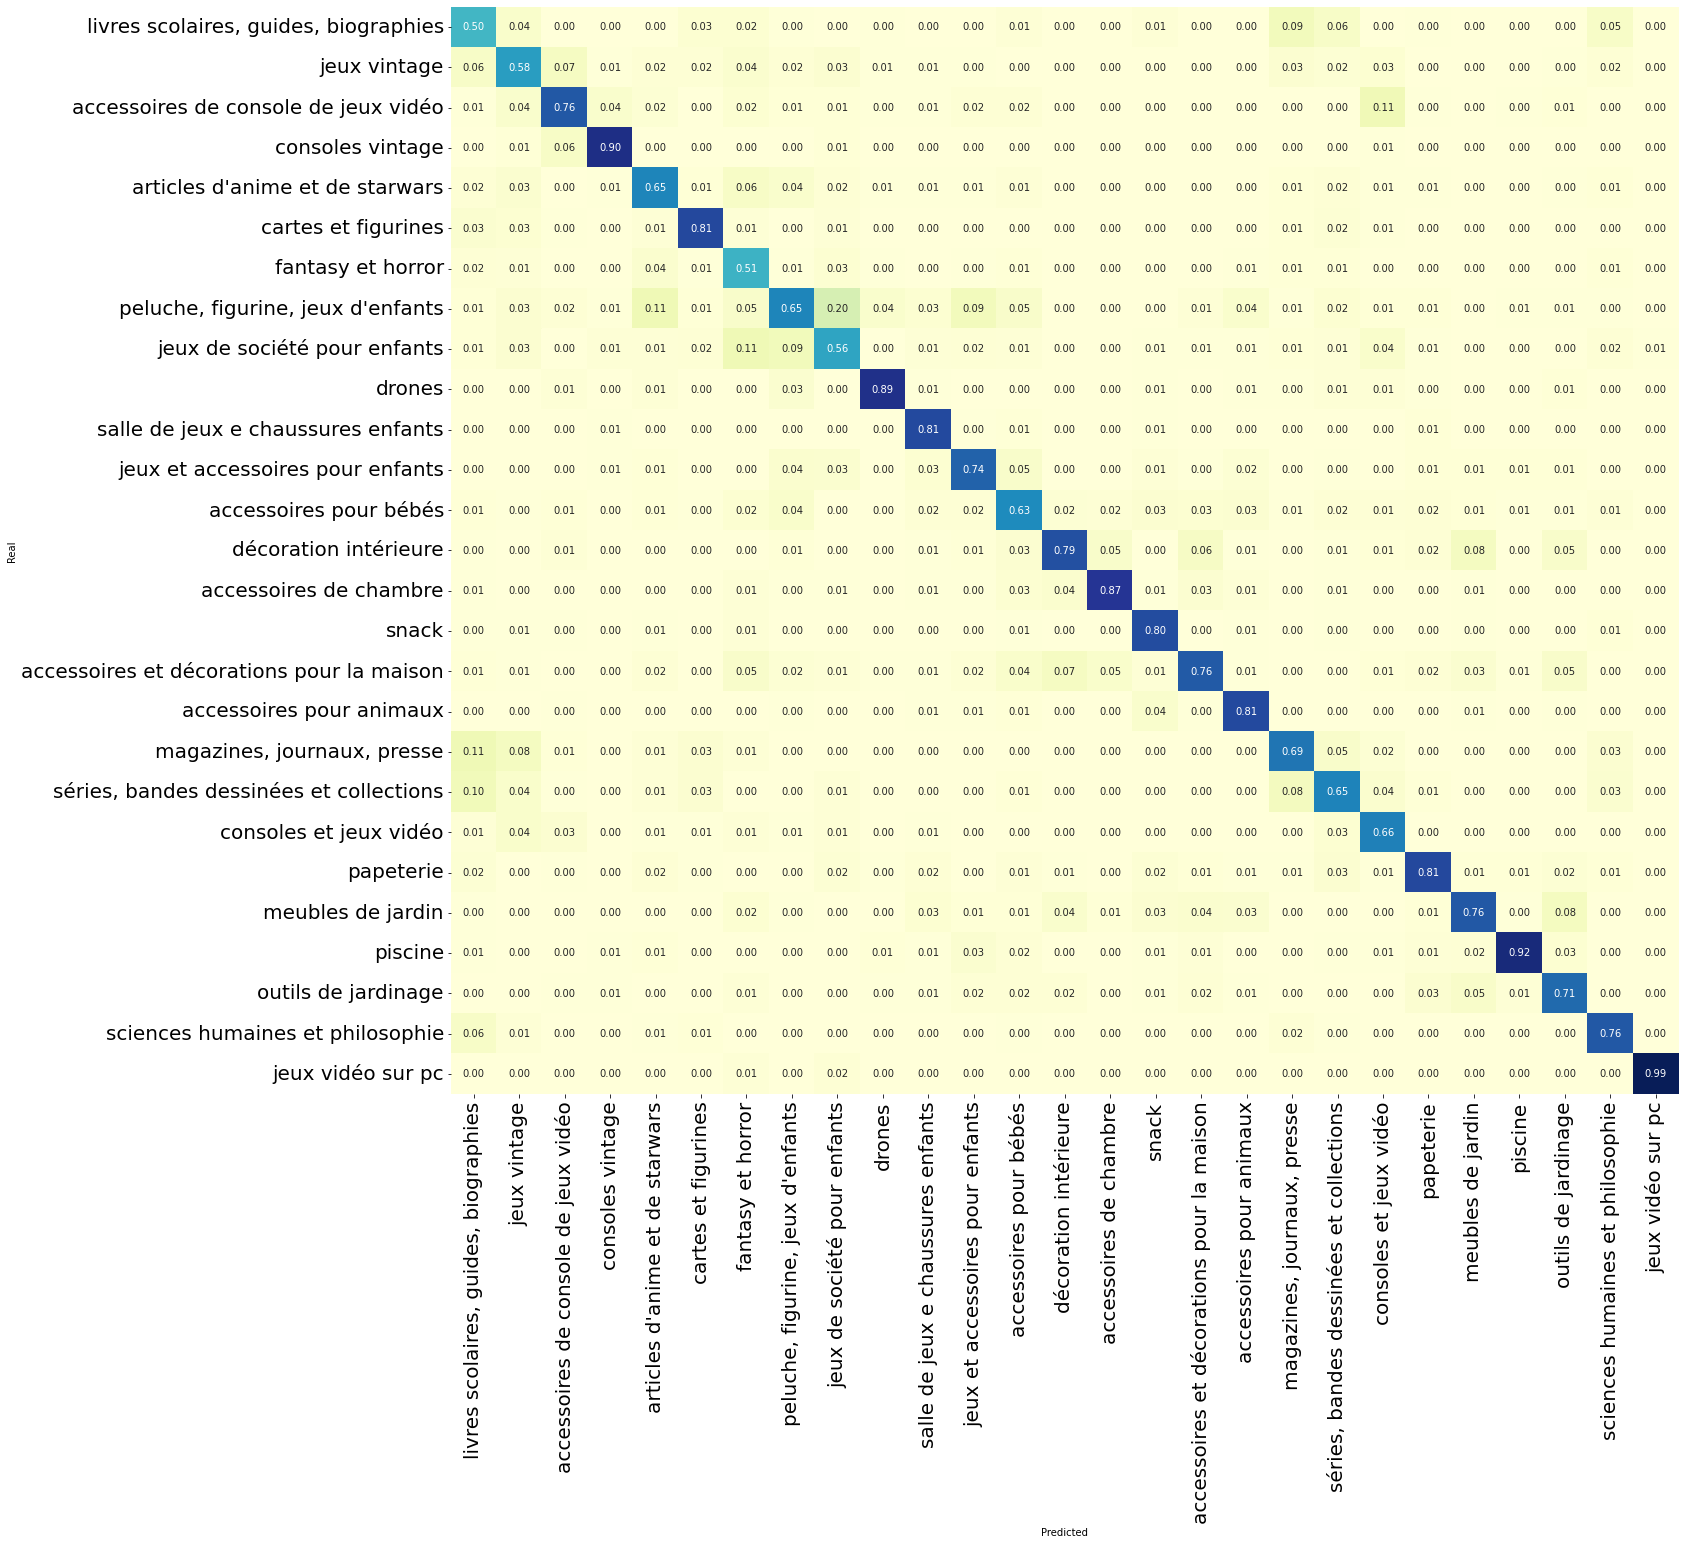

In [28]:
#-----------------------------------------------------------------------------------------------------
#plotting confusion matrix normalized by columns to show along the diagonal the precision of each class
#------------------------------------------------------------------------------------------------------

conf_matrix = pd.crosstab(A,B,rownames=["Real"],colnames=["Predicted"],normalize="columns")
plt.figure(figsize=(22,20))
tick_labels = [j for k,j in sorted(dic.items())]
ax = plt.subplot()
sns.heatmap(conf_matrix, fmt='.2f',annot=True,cmap="YlGnBu", cbar=False,ax=ax)
ax.xaxis.set_ticklabels(tick_labels,rotation=90,fontsize=20);
ax.yaxis.set_ticklabels(tick_labels, rotation=0,fontsize=20);

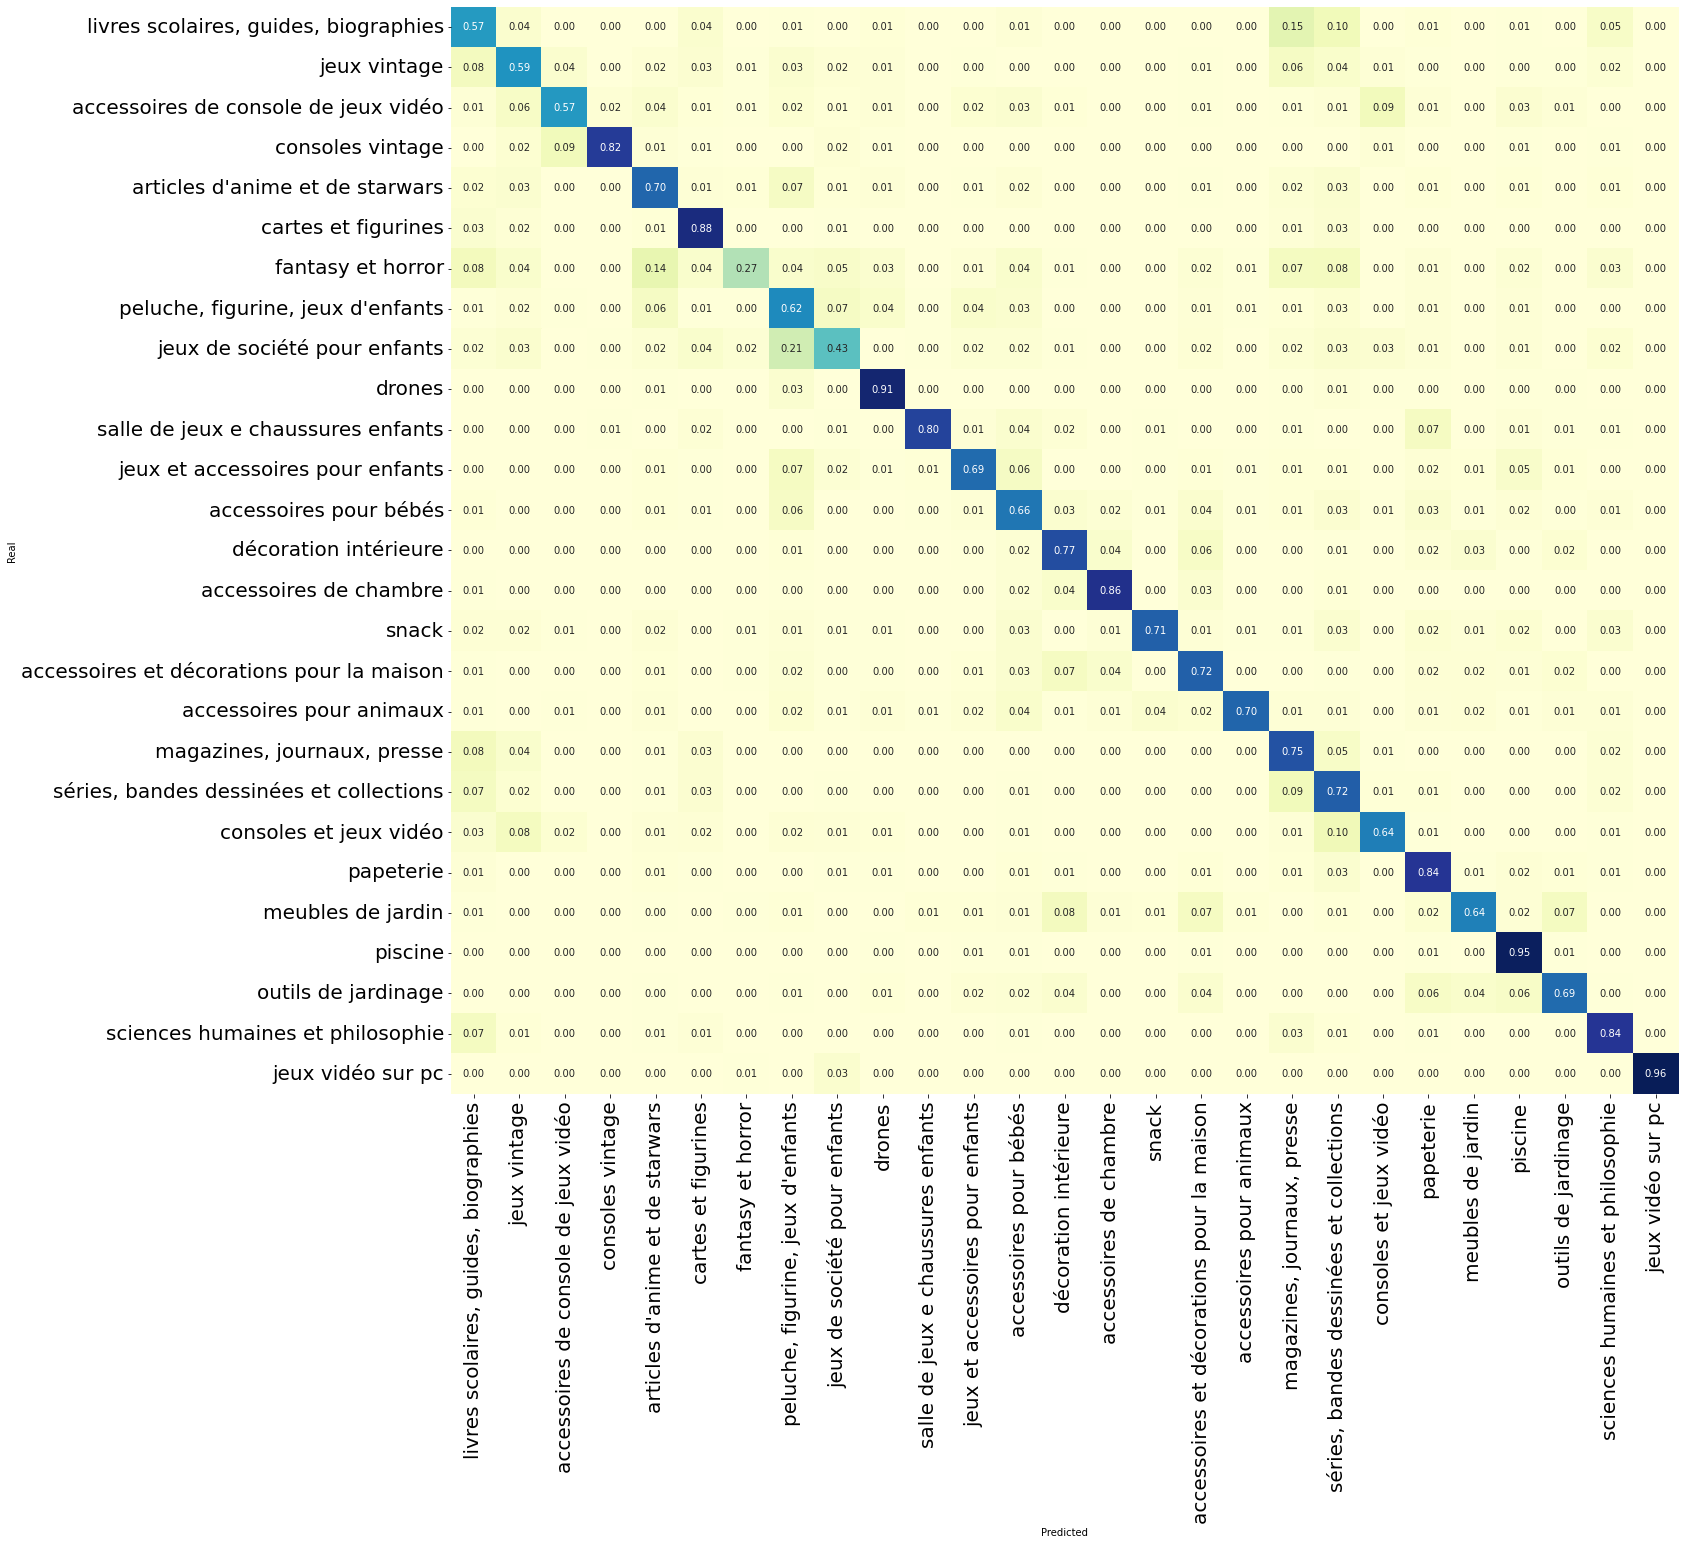

In [29]:
#-----------------------------------------------------------------------------------------------------
#plotting confusion matrix normalized by rows to show along the diagonal the recall of each class
#------------------------------------------------------------------------------------------------------

conf_matrix = pd.crosstab(A,B,rownames=["Real"],colnames=["Predicted"],normalize="index")
plt.figure(figsize=(22,20))
tick_labels = [j for k,j in sorted(dic.items())]
ax = plt.subplot()
sns.heatmap(conf_matrix, fmt='.2f',annot=True,cmap="YlGnBu", cbar=False,ax=ax)
ax.xaxis.set_ticklabels(tick_labels,rotation=90,fontsize=20);
ax.yaxis.set_ticklabels(tick_labels, rotation=0,fontsize=20);

In [30]:
# #print the categories which have been misclassified most by our predictions (> 50 times)
# conf_matrix_not_norm = conf_matrix = pd.crosstab(A,B,rownames=["Real"],colnames=["Predicted"])

# for i, j in itertools.product(conf_matrix_not_norm.index,conf_matrix_not_norm.index):
#     if (conf_matrix_not_norm.loc[j,i] > 50 and i!=j):
#         print("The category '{0}' has been {1} times classified as '{2}'".format(dic[j],conf_matrix_not_norm.loc[j,i],dic[i]))
    


The confusion matrices show that the category  "livres scolaires, guides, biographies" has the lowest precision, this is due to the fact that many items predict to belong to that category, in fact belong to "séries, bandes dessinées et collections" and "magazines, journaux, presse" categories. On the other hand the 'fantasy et horror' category has the lowest recall, indeed 30% of the times this category is predicted as 'livres scolaires, guides, biographies', "articles d'anime et de starwars" and "peluche, figurine, jeux d'enfants"  


# Hybrid model
---
  A hybrid deep learning model taking as input both images and text features has been devised by concatenation of two different deep learning architecture: an RNN (featureing an LSTM layer) and a CNN based. 

In [31]:
#definitio of a new variable "text" by joining together the "description" and "designation" variables
df_clean = df.copy()
df_clean["text"] = df_clean["designation"].fillna("").astype("str") + ". "+ df_clean["description"].fillna("").astype("str")

- Removing punctuations, html characters, tags and stopwords

In [32]:
import re
df_clean["text"]=df_clean["text"].astype(str).str.lower()

#removing tags and html characters
df_clean['text_no_html']=df_clean['text'].apply(lambda x : remove_tags(x))
df_clean['text_no_html']=df_clean['text_no_html'].apply(lambda x : remove_html_code(x))

#tokenization of the variable "text_no_html"
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer('\w+')

#tokenization
df_clean['text_token']=df_clean['text_no_html'].apply(regexp.tokenize)

#delete english,french and german stopwords
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
stop_words_ge = set(stopwords.words("german"))
stop_words_fr = set(stopwords.words("french"))
stop_words_en = set(stopwords.words("english"))
stop_words = set.union(stop_words_en,stop_words_fr,stop_words_ge)
stop_words.update("nan")
df_clean["text_token"] = df_clean["text_token"].apply(lambda x: [item for item in x if item not in stop_words])
df_clean['text_no_stopwords'] = df_clean['text_token'].apply(lambda x:' '.join([word for word in x if len(word) > 2]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Defining a preprocessing function to vectorize the text variable and split into train and test sets.

In [33]:
#text vectorizer initialization 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50000,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True)

# creating test and training set for text classification through the preprocessing function defined above
tokenizer,word2idx,idx2word,vocab_size,X_train,X_test,df_train,df_test = preprocessing(df_clean,tokenizer)

- Definition of Deep Learning model for text classification

In [34]:

embedding_dim = 200

lstm = Sequential()
lstm.add(Embedding(50000, embedding_dim)) #comment
lstm.add(LSTM(128, activation="tanh",return_sequences=True)) #comment
lstm.add(Dropout(0.3)) #comment
lstm.add(GlobalAveragePooling1D())
lstm.add(Dense(256, activation='relu'))
lstm.add(Dropout(0.3))
# model.add(Dense(27, activation='softmax'))


In [35]:
#creating train and test sets for image classification 
X_train_im,y_train_im, class_indices_train = extract_images(df_train)
X_test_im,y_test_im, class_indices_test = extract_images(df_test)

Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


- Definition of Deep Learning model for image classification

In [36]:
base_model = VGG16(weights='imagenet', include_top=False,  input_shape = (width, height,3))
# Freeze the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False
lenet = Sequential()

# adding the VGG16 model
lenet.add(base_model) 
lenet.add(Flatten())
lenet.add(Dense((4096),activation='relu'))
lenet.add(BatchNormalization())
lenet.add(Dropout(0.5))

In [37]:
#create the input to our final set of layers as the output of both lenet and lstm models
combined_input = concatenate([lstm.output,lenet.output])
x = Dense(27, activation='softmax') (combined_input)
model = Model(inputs = [lstm.input,lenet.input], outputs=x)

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    10000000    ['embedding_input[0][0]']        
                                                                                                  
 vgg16_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 128)    168448      ['embedding[0][0]']              
                                                                                              

In [39]:
#compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [40]:
model.fit(x=[X_train,X_train_im],y=y_train_im,epochs=10,batch_size=128,validation_split=0.2)
# with open(model_savepath+"hybrid_LSTM_CMM_image_text.pkl", 'wb') as f:
#     pickle.dump(model, f)

Epoch 1/10
425/425 [==============================] - 69s 150ms/step - loss: 2.4980 - accuracy: 0.3578 - val_loss: 2.0457 - val_accuracy: 0.4339
Epoch 2/10
425/425 [==============================] - 62s 146ms/step - loss: 1.9519 - accuracy: 0.4425 - val_loss: 1.9419 - val_accuracy: 0.4475
Epoch 3/10
425/425 [==============================] - 62s 145ms/step - loss: 1.7417 - accuracy: 0.4851 - val_loss: 1.7696 - val_accuracy: 0.4778
Epoch 4/10
425/425 [==============================] - 62s 145ms/step - loss: 1.5246 - accuracy: 0.5368 - val_loss: 1.6398 - val_accuracy: 0.5276
Epoch 5/10
425/425 [==============================] - 62s 145ms/step - loss: 1.3557 - accuracy: 0.5835 - val_loss: 1.5353 - val_accuracy: 0.5576
Epoch 6/10
425/425 [==============================] - 62s 145ms/step - loss: 1.2141 - accuracy: 0.6202 - val_loss: 1.4608 - val_accuracy: 0.5753
Epoch 7/10
425/425 [==============================] - 62s 146ms/step - loss: 1.0781 - accuracy: 0.6616 - val_loss: 1.4027 - val_ac

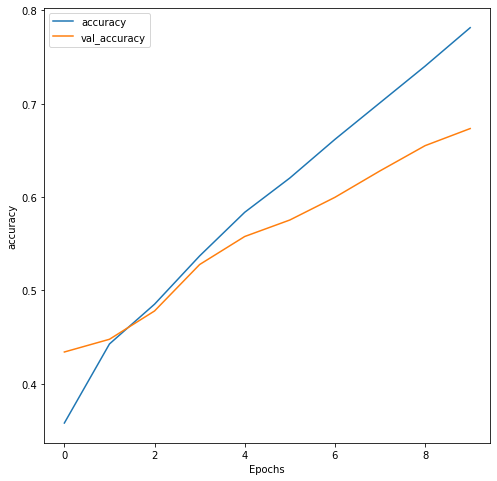

In [41]:
plot_graphs(model.history, "accuracy")

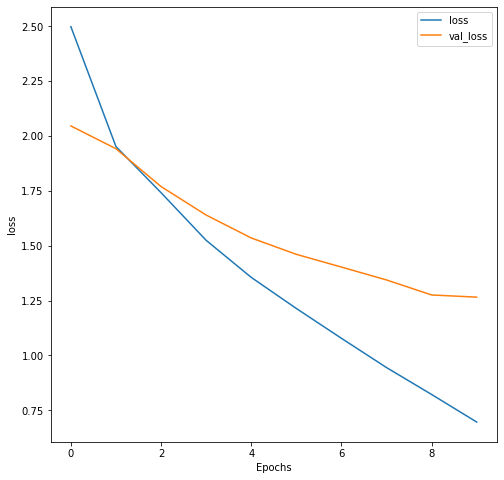

In [42]:
plot_graphs(model.history, "loss")

The minimum of the validation loss has been reached at the 7th epoch with a validation accuracy of 0.67. Indeed after the 7th epoch the validation loss start increasing while the training loss decreses indicating that the model is overfitting. Again this model did not improve the accuracy showed by the LSTM model applied on the text alone, thereby indicating that the inclusion of the images as input to our Deep Learning model is useless. 

In [43]:
#Predictions
y_pred_hybrid_prob = model.predict([X_test,X_test_im])

In [44]:
#From class probabilities to class labels
y_pred_hybrid = np.argmax(y_pred_hybrid_prob,axis=1)

y_train_im_label = np.argmax(y_train_im,axis=1)
y_test_im_label = np.argmax(y_test_im,axis=1)

In [45]:
#------------------------------------------------------------
#mapping the labels to the initial prdtypecode categories
#-----------------------------------------------------------

#inverting key-values of class_indices dictionary containing the mapping between the labels and the prdtypecode categories
class_indices_test = {v: k for k, v in class_indices_test.items()}

#replacing label with prdtypecode category through the class_indices_test_dictionary
y_pred_hybrid_class = [class_indices_test[index] for index in y_pred_hybrid]
y_test_im_label_class = [class_indices_test[index] for index in y_test_im_label]
y_train_im_label_class = [class_indices_test[index] for index in y_train_im_label]

In [46]:
print(classification_report(y_test_im_label_class,y_pred_hybrid_class))

              precision    recall  f1-score   support

          10       0.53      0.53      0.53       623
        1140       0.71      0.36      0.47       534
        1160       0.69      0.88      0.77       791
        1180       0.26      0.22      0.24       153
        1280       0.52      0.56      0.54       974
        1281       0.30      0.42      0.35       414
        1300       0.75      0.88      0.81      1009
        1301       0.84      0.55      0.67       161
        1302       0.50      0.55      0.53       498
        1320       0.57      0.44      0.50       648
        1560       0.70      0.73      0.72      1015
        1920       0.81      0.74      0.77       861
        1940       0.76      0.35      0.48       161
        2060       0.65      0.70      0.67       999
        2220       0.61      0.45      0.52       165
        2280       0.65      0.75      0.69       952
        2403       0.68      0.71      0.69       955
        2462       0.63    

The classification report shows that the categories 10 ('livres scolaires, guides, biographies'), 1140 ("articles d'anime et de starwars") and 1281 ('jeux de société pour enfants') have very low scores. This latter having both precision and recall below 40%. Moreover, the category 1180 ('fantasy et horror') has the lowest recall. 

### Confusion Matrix

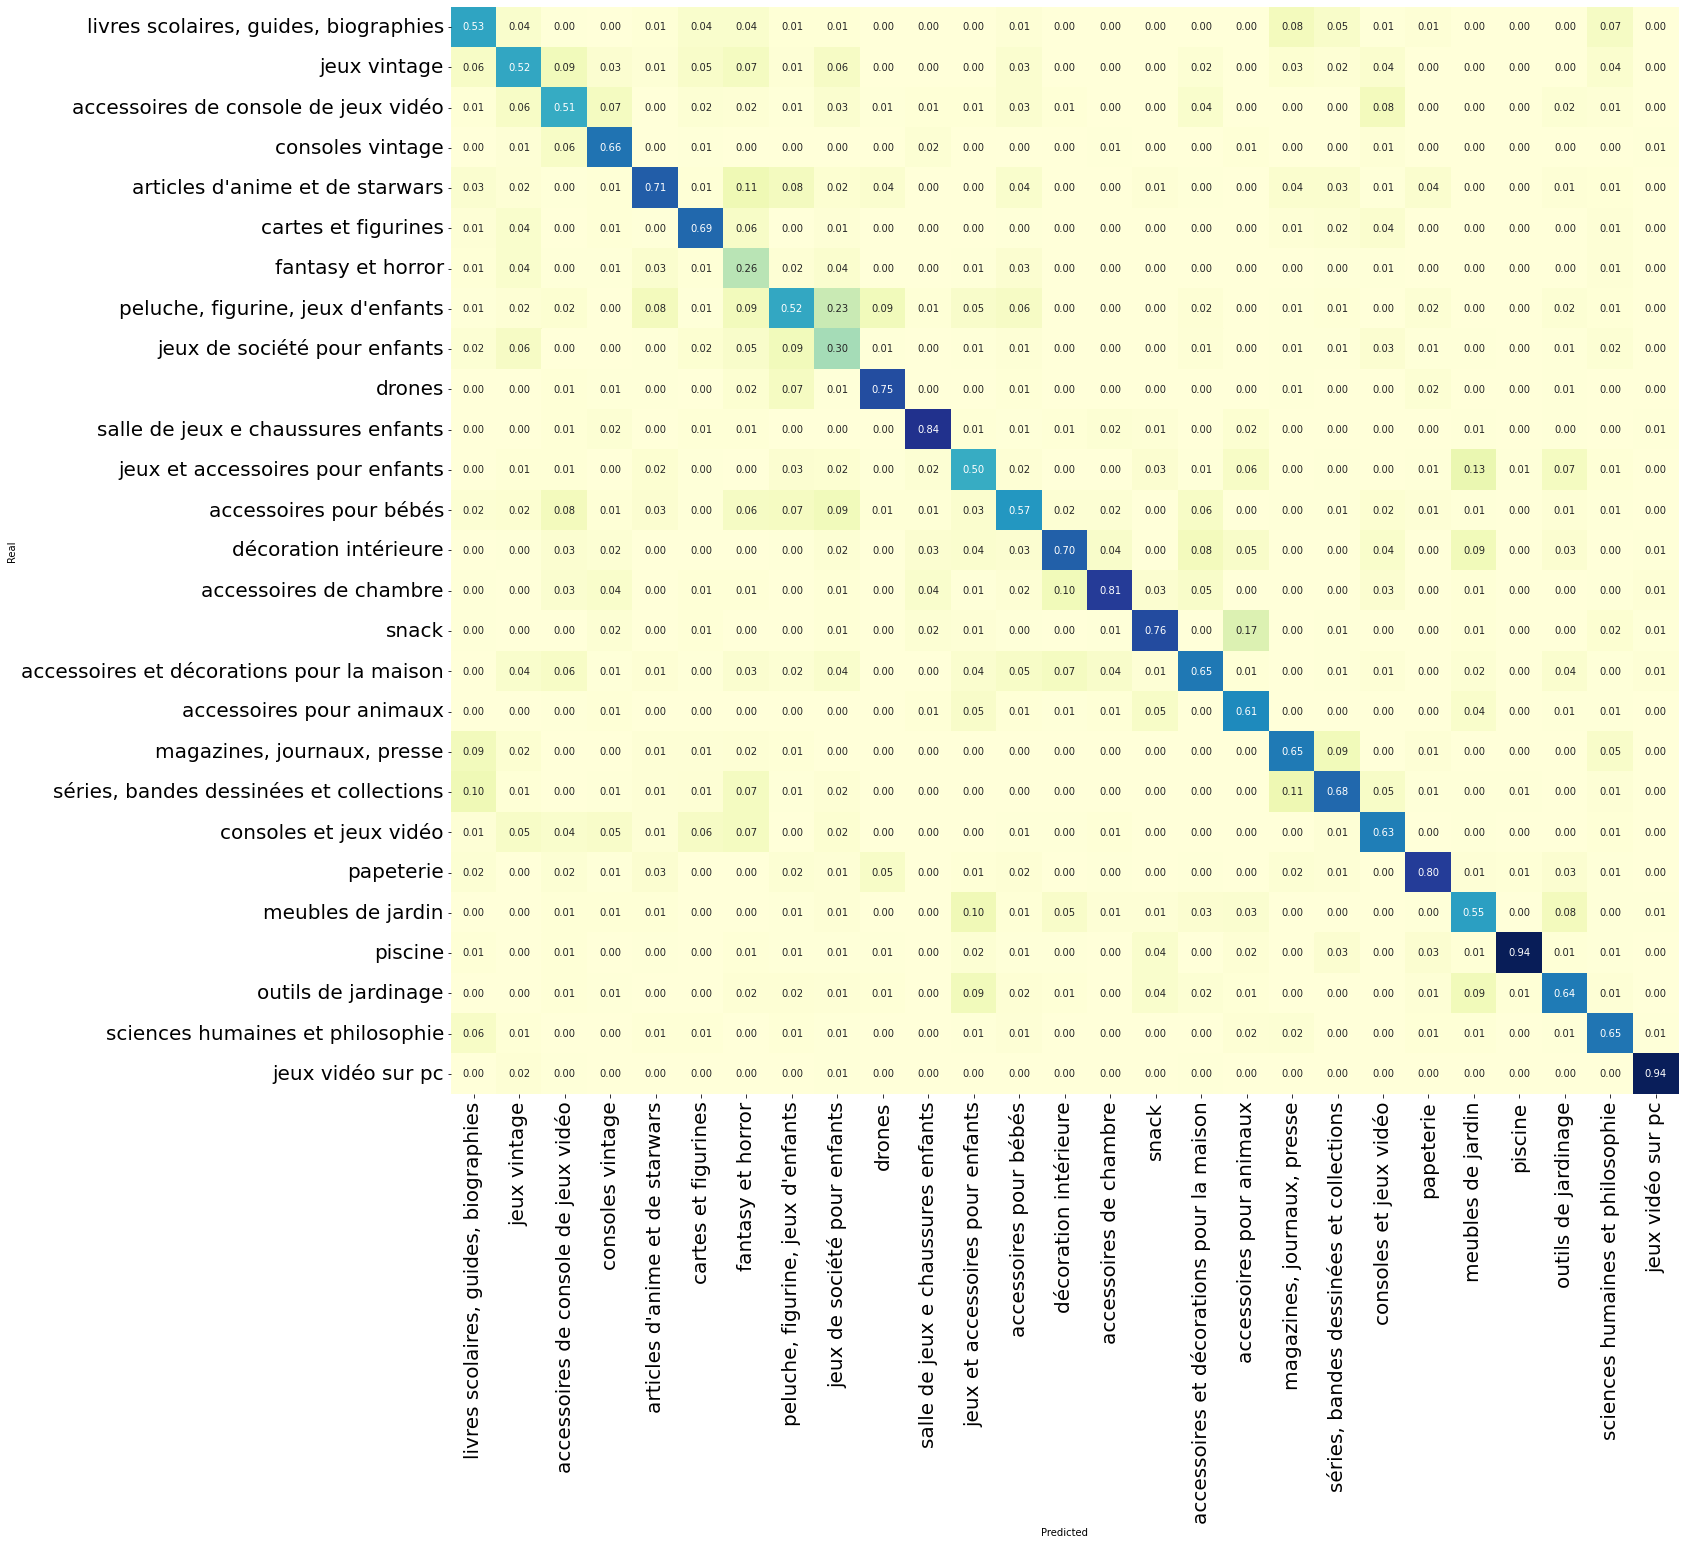

In [47]:
#-----------------------------------------------------------------------------------------------------
#plotting confusion matrix normalized by columns to show along the diagonal the precision of each class
#------------------------------------------------------------------------------------------------------

#converting list of classes as string into numpy array of integers for plotting confusion matrix
A = np.array(y_test_im_label_class).astype("int")
B =  np.array(y_pred_hybrid_class).astype("int")

conf_matrix = pd.crosstab(A,B,rownames=["Real"],colnames=["Predicted"],normalize="columns")
plt.figure(figsize=(22,20))
tick_labels = [j for k,j in sorted(dic.items())]
ax = plt.subplot()
sns.heatmap(conf_matrix, fmt='.2f',annot=True,cmap="YlGnBu", cbar=False,ax=ax)
ax.xaxis.set_ticklabels(tick_labels,rotation=90,fontsize=20);
ax.yaxis.set_ticklabels(tick_labels, rotation=0,fontsize=20);

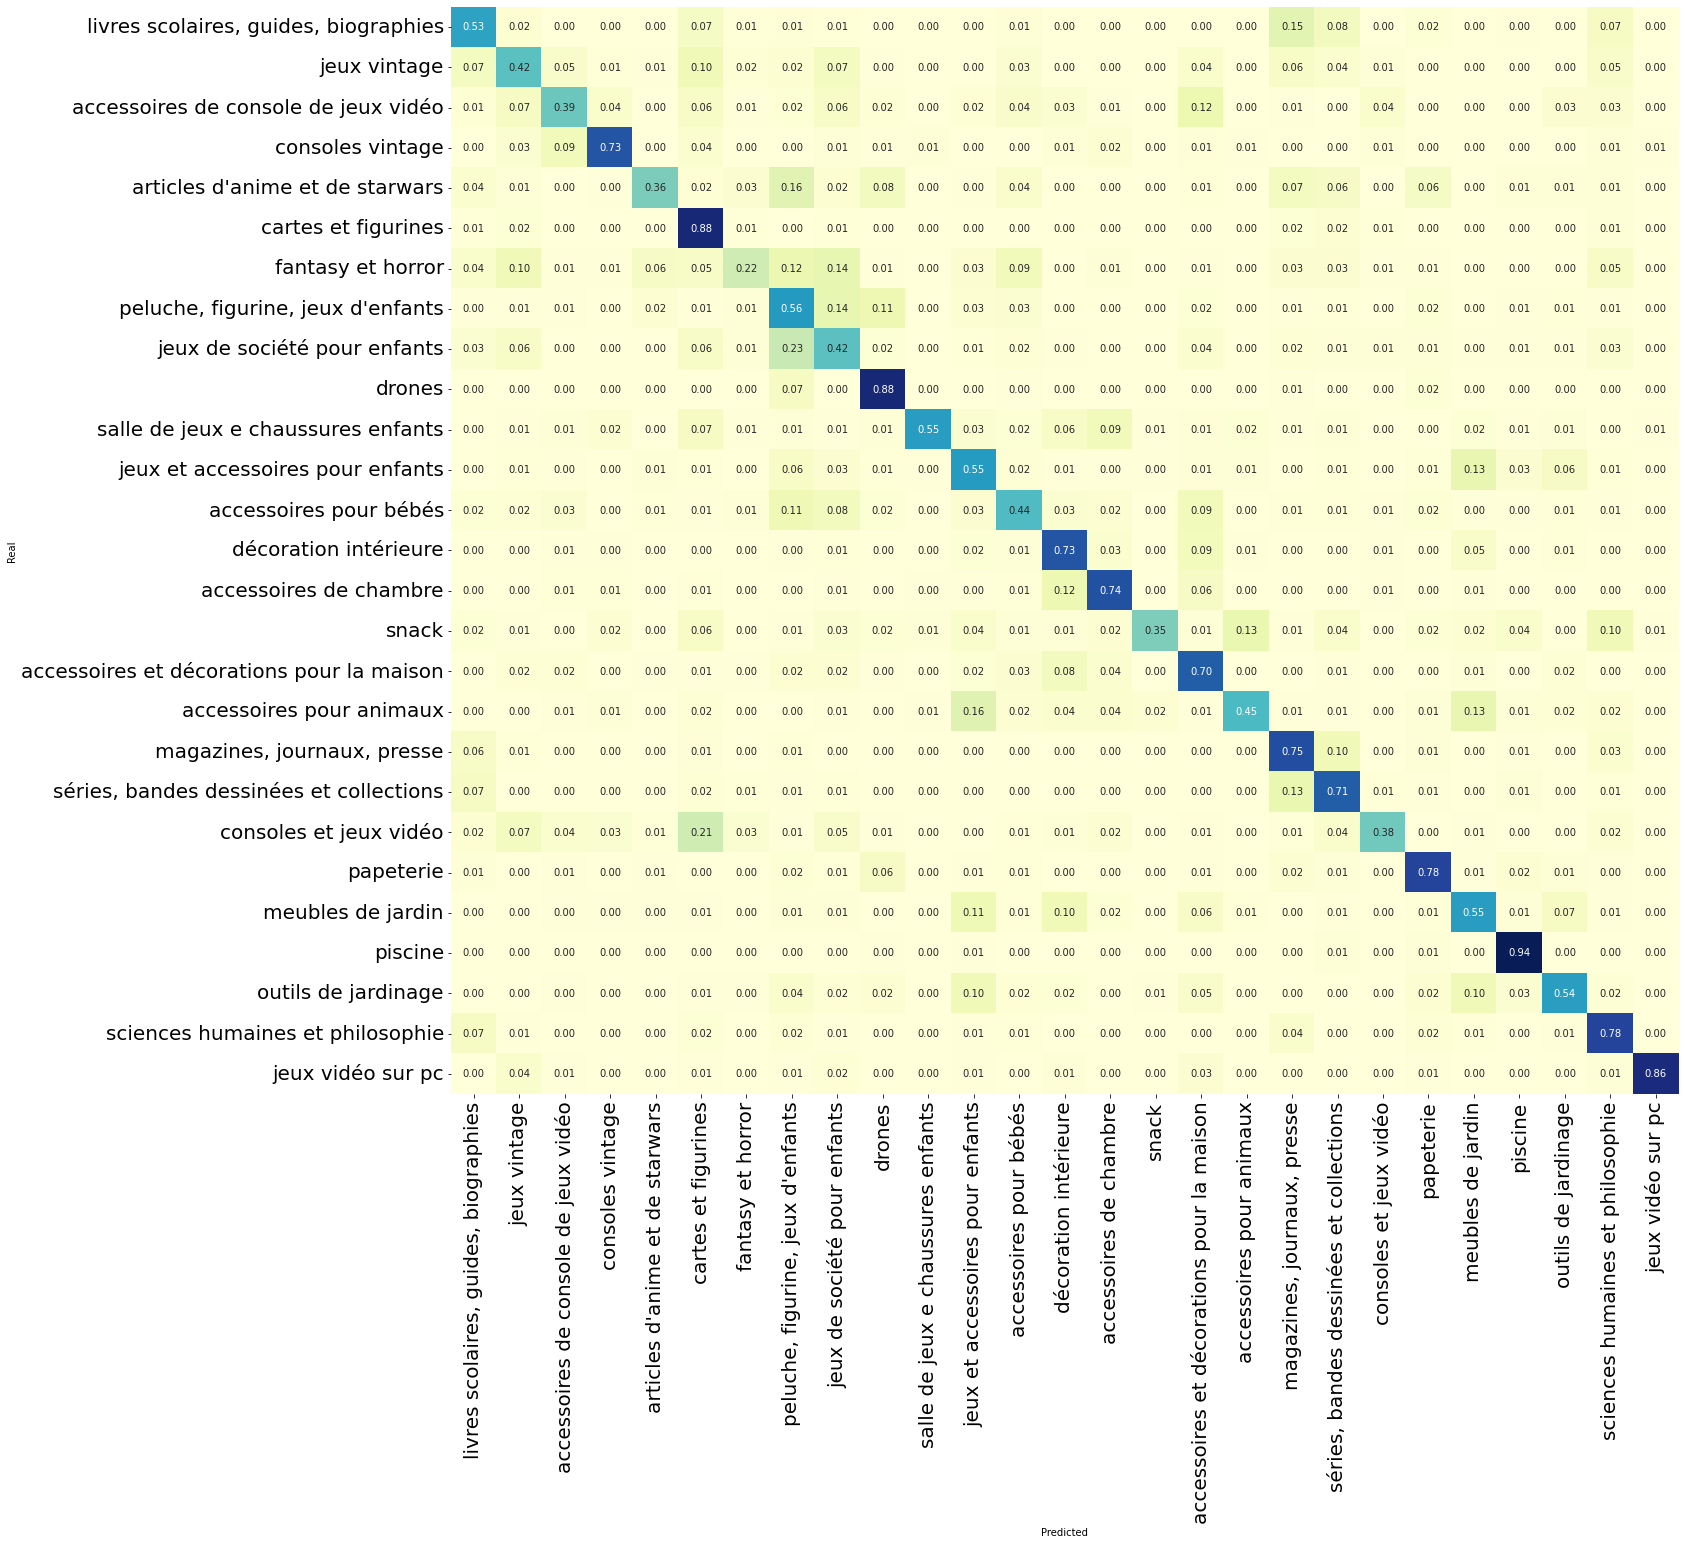

In [48]:
#-----------------------------------------------------------------------------------------------------
#plotting confusion matrix normalized by rows to show along the diagonal the recall of each class
#------------------------------------------------------------------------------------------------------

conf_matrix = pd.crosstab(A,B,rownames=["Real"],colnames=["Predicted"],normalize="index")
plt.figure(figsize=(22,20))
tick_labels = [j for k,j in sorted(dic.items())]
ax = plt.subplot()
sns.heatmap(conf_matrix, fmt='.2f',annot=True,cmap="YlGnBu", cbar=False,ax=ax)
ax.xaxis.set_ticklabels(tick_labels,rotation=90,fontsize=20);
ax.yaxis.set_ticklabels(tick_labels, rotation=0,fontsize=20);

By analysing the confusion matrices, we can see that the class "Jeux de société pour enfants" has a very low precisin and recall. Indeed, 20% of the items assigned by out model to that category in reality belong to the "Peluche, figurine, jeux d'enfants" category. However, the category having the worst recall (0.12) is the prdtypecode 1180 ('fantasy et horror').

# Final Remarks
---
The machine learning model augmented with features extracted from images through a pre-trained VGG16 neural network did not provide a better score than the simple machine learning model trained on the encoded text which was tested separately (Machine Learning Notebook) and provided a score of 0.81. 
The hybrid CNN/RNN model also provided a score around 0.7 which was already achieved by a single RNN model trained on the text.
Therefore, apparently the image provided together with the dataset did not help model in the prediction stage. It is worth to remark that the size of the images has been reduced to 64x64 due to limited amount of RAM available. It would be interesting to see what happens by increasing the size of the images.
However, globally the Machine Learning models applied perform better than the Deep Learning ones for this particular case. Indeed, despite the RNN is known to take into consideration the sequentiality of words in a sentence, it did not provide a better score than Logistic Regression. This is probably due to the fact that the dataset contains short-summarized items descriptions where it is not very important to capture the meaning of the sentence as whole. On the other hand, the frequency of each single word within the text captured by the Count Vectorized is more significative for the correct prdtypecode assignation.   
 